In [ ]:
# Задание 1.1. Необходимо вывести доход, который принесли только хорошие клики (good_clicks)?
%%sql
SELECT SUM(revenue) AS good_clicks_revenue
FROM stat_collector
WHERE fraud_clicks = 0;

In [ ]:
# Задание 1.2. Необходимо вывести топ-10 сайтов по обороту среди тех, которые имеют более 25% плохих кликов.
%%sql
SELECT bd.domain_name, 
       SUM(sc.revenue) AS total_revenue
FROM block_domains bd
JOIN stat_collector sc ON bd.block_id = sc.block_id
WHERE sc.fraud_clicks / NULLIF(sc.good_clicks + sc.fraud_clicks, 0) > 0.25
GROUP BY bd.domain_name
ORDER BY total_revenue DESC
LIMIT 10;

**Задание по анализу данных**

Кейс
Рекламодатель Сигма жалуется на постоянный рост CPA по своим рекламным кампаниям в последние 4 месяца (с июня по сент 2022). 
Ваша задача проанализировать его размещение с целью: 
1) Выяснить причину растущего CPA 
2) Дать рекомендации по снижению и стабилизации CPA до целевого значения (380 руб)


**Решение:**

In [1]:
# Подключим апару библиотек для работы с данными
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1, palette="Set2")

import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
# Считаем данные
df = pd.read_excel('Задание_стажировка_рекламный аналитик_2024.xlsx',
                   sheet_name='data')

In [3]:
# Сделаем преобразования данных:
# Рассмотрим данные касающиеся только нашего рекламодателя
df = df[df.Client == 'Сигма']
df.drop('Client', axis=1, inplace=True)

# Ограничим время с июня по сентябрь
start = pd.Timestamp('2022-06-01 00:00:00')
end = pd.Timestamp('2022-09-01 00:00:00')
df = df[(df.Month >= start) & (df.Month <= end)].reset_index(drop=True)
df.Month = pd.to_datetime(df.Month).dt.month.astype(str)
month_mapping = { '6': 'June', '7': 'July', '8': 'August', '9': 'September'}
df.Month = df.Month.map(month_mapping).fillna(df.Month)

# Добавим столбец CPA
df['cpa'] = df.Cost / df.Conversions
df.fillna(0, inplace=True)
# Категориальные признаки
categorical_features = ['Month', 'Category', 'Device', 'Place', 'BannerType', 'QueryType (search only)', 'TargetingType']

Посмотрим какими категориями пользуется наш клиент:

In [4]:
# Когда не нужно описание данных в условии задачи,
# чтобы обратить на них внимание))))
df.Category.value_counts().sort_index()

Category
ВКЛАДЫ                            40
ДЕБЕТОВЫЕ КАРТЫ                   51
ИПОТЕЧНОЕ КРЕДИТОВАНИЕ            64
КРЕДИТНЫЕ КАРТЫ                   60
ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ      79
РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ    72
Name: count, dtype: int64

Чтобы понять почему поднялся показать CPA посмотрим какое влияние на него оказали другие факторы. Для этого представим нашу модель как линейную регрессию и обучим ML алгоритмом, после чего посмотрим каковы коэффициенты влияния на целевой признак.

Расммотрим каждый фактор в отдельности и посмотрим как менялось влияние других факторов на целевое значение.
Это поможет нам не только оценить причину динамики по месяцам, но и оценить влияние в принципе (то есть посмотрим более общим образом на нашу задачу)

In [5]:

# Напишем очень умную функцию, которая в 1 клик выполнит наше 1000 и 1 желание

def analysis_coeff_by_column(feature):
    unique = df[feature].unique()
    dfs = [df[df[feature] == unique[i]] for i in range(len(unique))]
    
    plt.figure(figsize=(10, 6))
    
    coefficients_all_months = []
    for i, dataset in enumerate(dfs):
        # Подготовка данных к применению лин регрессии
        data = dataset.drop(feature, axis=1)
        inf_indices = np.isinf(data['cpa'])
        data = data[~inf_indices]
        categorical_features_new = categorical_features.copy()
        categorical_features_new.remove(feature)
        encoded_data = pd.get_dummies(data, columns=categorical_features_new, drop_first=True)
        # Разделение на признаки и целевую переменную
        drop_values = ['Conversions', 'cpa']
        X = encoded_data.drop(drop_values, axis=1)  # Исключаем целевые переменные
        y = encoded_data['cpa']  # Целевая переменная
    
        # Обучение линейной модели
        model = LinearRegression()
        model.fit(X, y)
        coefficients = model.coef_
        coefficients_all_months.append(coefficients)
        
        # Визуализация коэффициентов
        plt.plot(range(len(coefficients)), coefficients, label=f'{feature} = {dataset[feature].values[i]}')
    
    # Визуализация средней линии, легенды и описаний
    max_length = max(len(coeffs) for coeffs in coefficients_all_months)
    padded_coefficients = [np.pad(coeffs, (0, max_length - len(coeffs)), mode='constant', constant_values=np.nan) for coeffs in coefficients_all_months]
    coefficients_all_months_array = np.array(padded_coefficients)
    mean_coefficients = np.nanmean(coefficients_all_months_array, axis=0)
    plt.plot(range(len(mean_coefficients)), mean_coefficients, color='black', linestyle='--', label='Mean')
    plt.xticks(range(len(X.columns)), X.columns, rotation=90)
    plt.ylabel('Coefficient')
    plt.title(f'Coefficients of CPA Linear Model by {feature = :s}')
    plt.legend()
    plt.show()


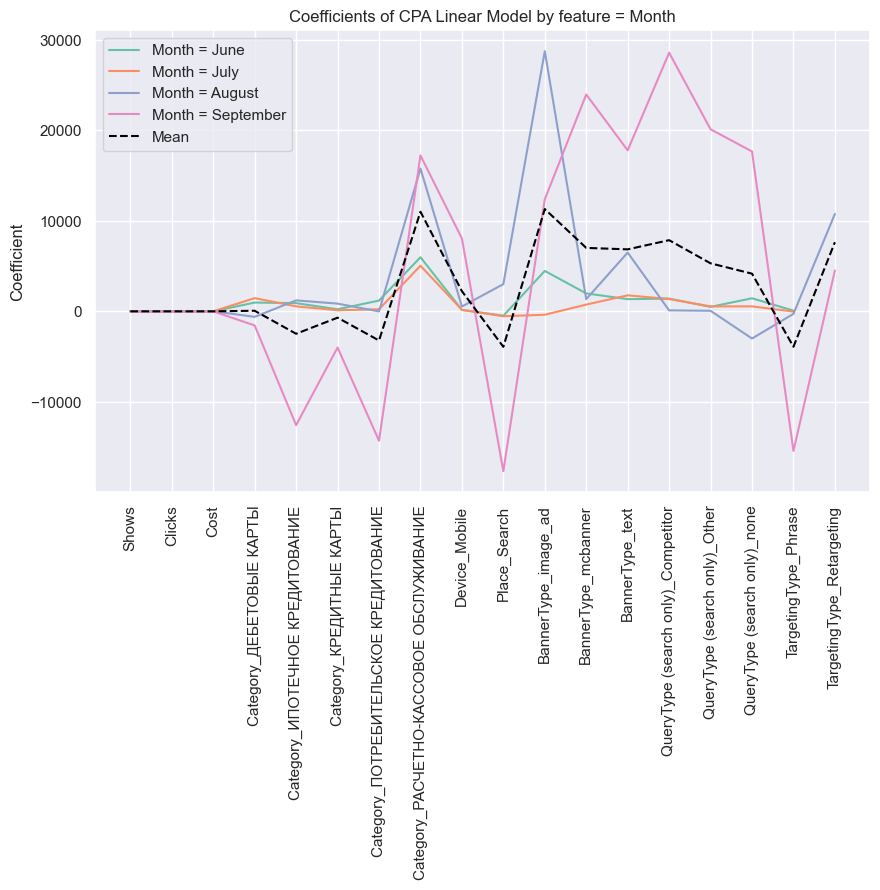

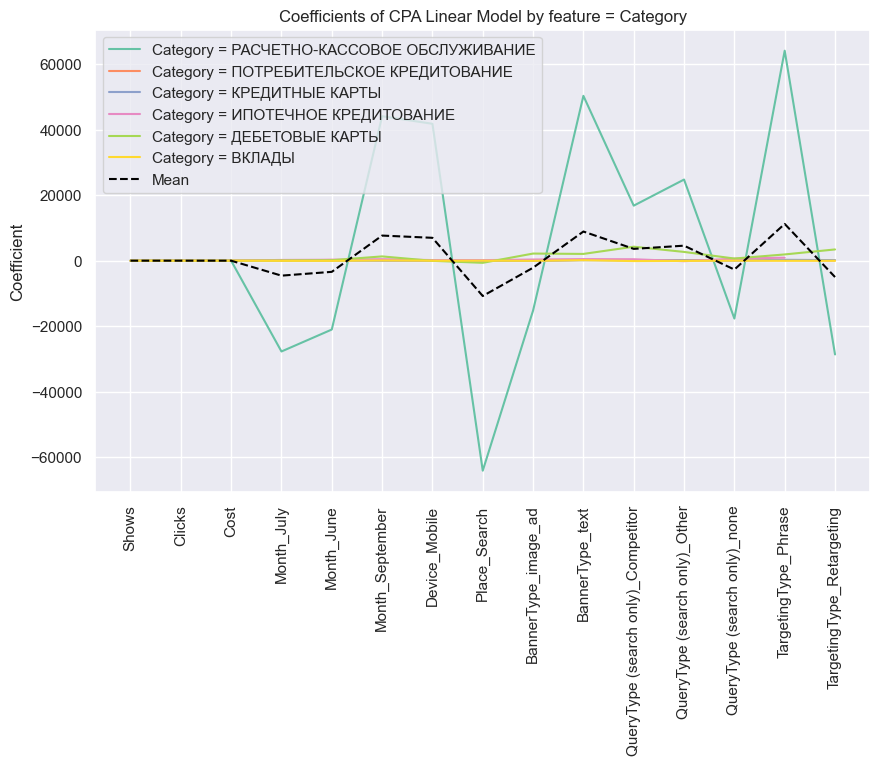

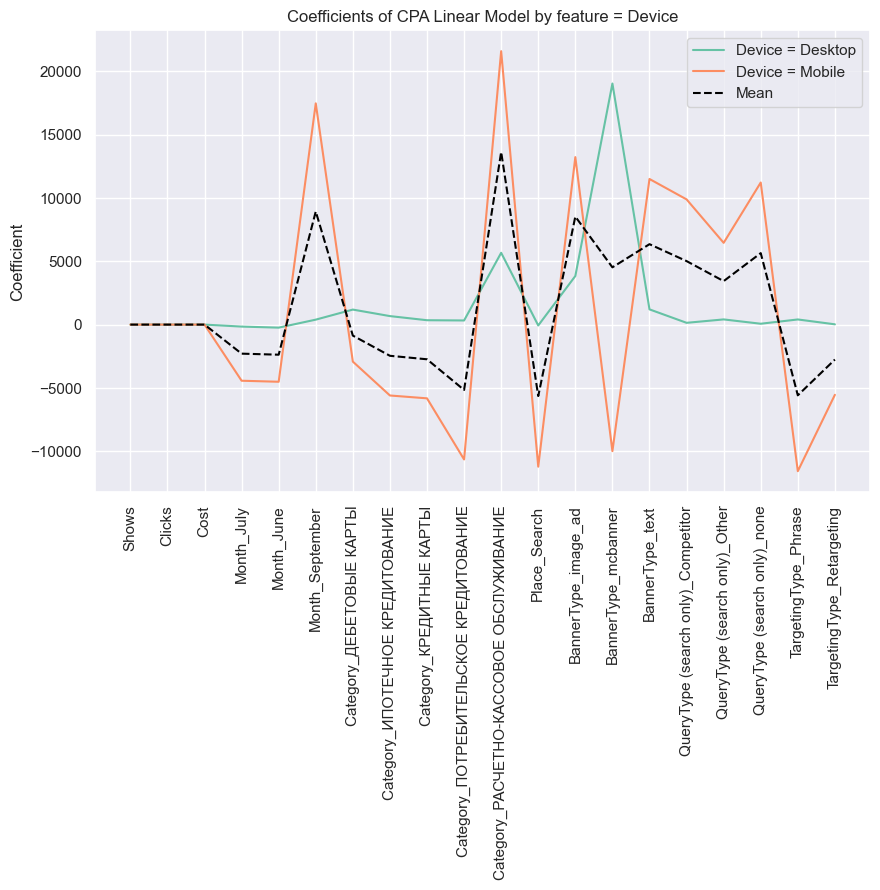

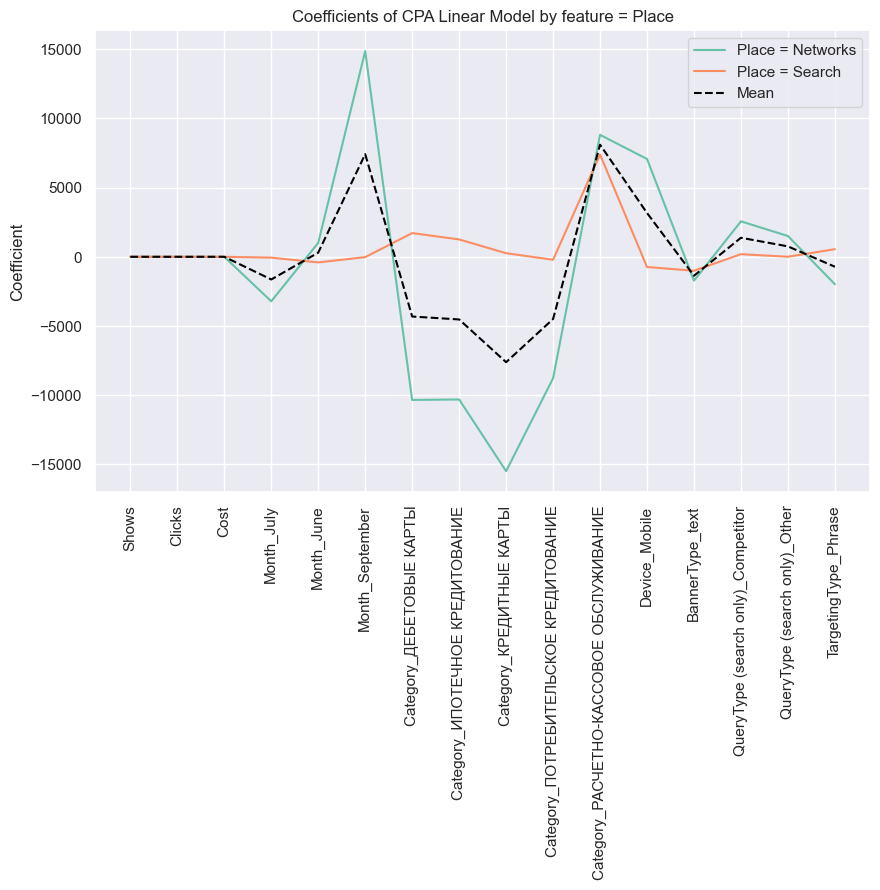

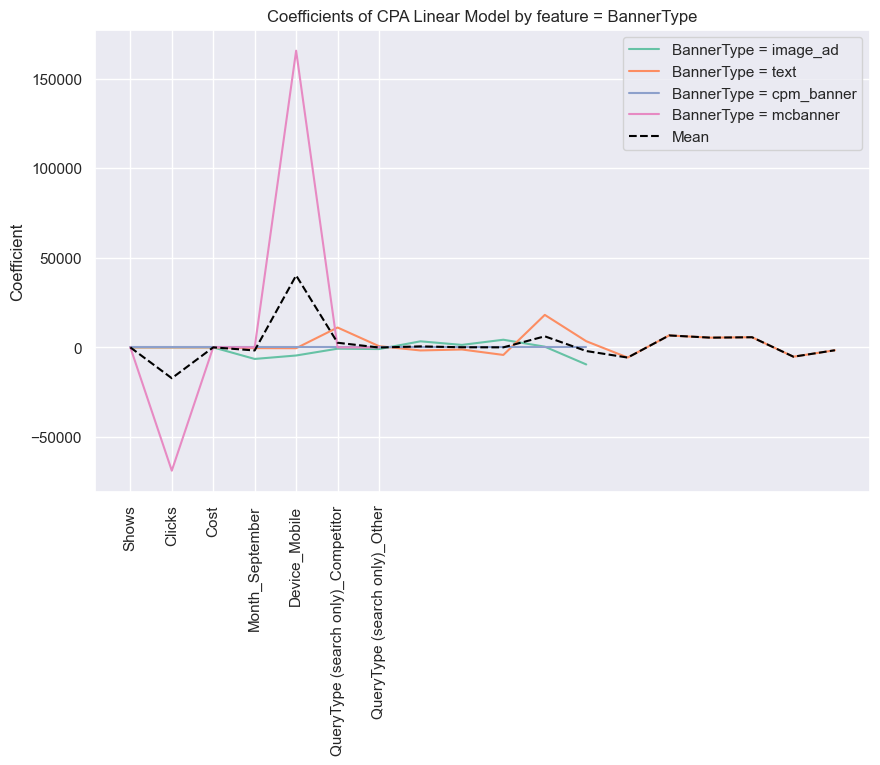

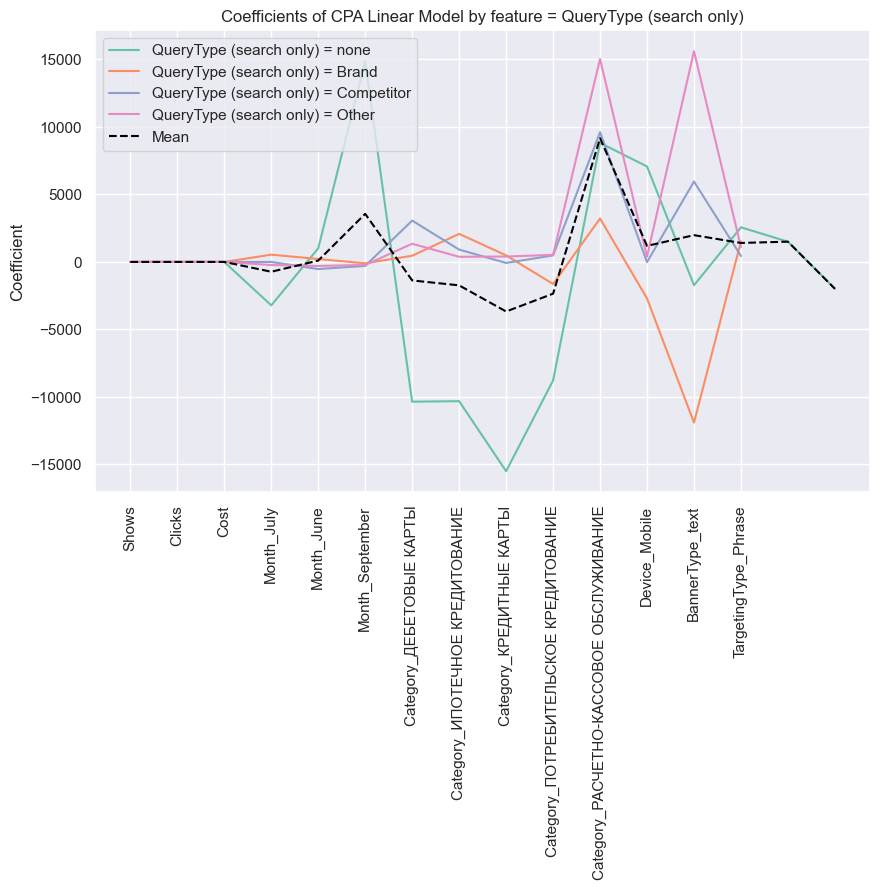

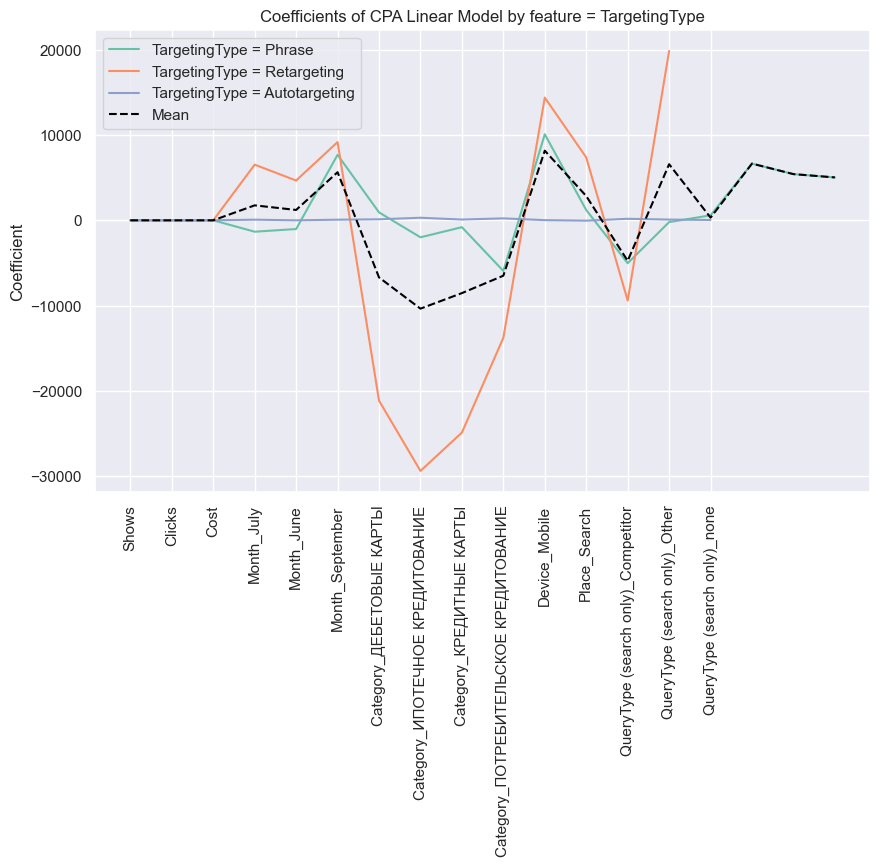

In [6]:
# поехали
for column in categorical_features:
    analysis_coeff_by_column(column)

**Выводы по графикам:**
1. (Месяцы)
- В основном CPA преимущественно поднялся в категории РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ, остальные особо не пострадали.
- Основной вклад в увеличение CPA сыграла реклама, размещенная в поиске, но также значимую роль сыграл текстовый тип обявлений.
2. (Категории)
- Вышло на поверхность, что на рост цены оказало влияние еще и TargetingType = Phrase, и подтвердиласть уверенность, что в остальных категориях разница менее значима.
3. (Девайсы)
- Здесь мы получили уточнение, что на рост CPA сыграла поисковая реклама, которая показывалась именно на телефонах, а та, что показывалась на компютерах - роли не сыграла.
4. (Место показа)
- Видно, что в категриях не являющихся "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" на площадках "Networkings" CPA напротив, упал.
5. (Тип баннера)
- На мобильных телефонах mcbanner с сильно высоким CPA. 
6. (Тип запроса)
- Связанные с брендом запросы уменьшили CPA, остальные увеличили.
7. (TargetingType)
- Здессь нет нашелось уникальной информативной составляющей.
